# High Frequency Words
Matthew Tillmawitz

For this assignment we will be analyzing the works of Shakespeare available in the NLTK corpuses. We will explore the unique vocabulary of the corpus and compare it to that of the wider corpus available from NLTK.

In [2]:
import nltk
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from nltk.corpus import shakespeare, gutenberg, stopwords
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
nltk.download('gutenberg', quiet=True)
nltk.download('stopwords', quiet=True)

True

We can see that, as one may expect, stop words make up just under half of the total size of our corpus. Upon removal, we are left with just shy of 7,500 unique words in the vocabulary of the corpus. Of these, only 319 words make up half the words present in the complete corpus excluding stop words. 

In [4]:
# Built in shakespeare corpus had lookup errors for some reason
shakespear_files = [file for file in gutenberg.fileids() if 'shakespeare' in file.lower()]
shakespeare_words = []
for file in shakespear_files:
    shakespeare_words.extend(gutenberg.words(file))

shakespeare_words_lower = [word.lower() for word in shakespeare_words if word.isalpha()]

print(f"Total words in Shakespeare corpus: {len(shakespeare_words_lower):,}")

Total words in Shakespeare corpus: 69,340


In [5]:
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in shakespeare_words_lower if word not in stop_words]

print(f"Words after removing stop words: {len(filtered_words):,} ({len(filtered_words) / len(shakespeare_words_lower) * 100:.2f}%)")
print(f"Unique words (with stop words removed): {len(set(filtered_words)):,}\n")

Words after removing stop words: 37,032 (53.41%)
Unique words (with stop words removed): 7,429



In [6]:
word_freq = Counter(filtered_words)
most_common = word_freq.most_common(20)

total_word_count = sum(word_freq.values())
half_corpus = total_word_count / 2
cumulative_count = 0
words_for_half = 0

for word, count in word_freq.most_common():
    cumulative_count += count
    words_for_half += 1
    if cumulative_count >= half_corpus:
        break

print(f"\n{words_for_half} unique words represent half of the corpus")
print(f"That's {words_for_half / len(word_freq) * 100:.2f}% of unique words")


319 unique words represent half of the corpus
That's 4.29% of unique words


The top 200 words consist of a varied vocabulary largely relating to the topics and settings of the plays included in the sample. The vocabulary is very different from what one might expect to see in the modern day, although technically still modern english.

In [14]:
top_200 = word_freq.most_common(200)
df_top_200 = pd.DataFrame(top_200, columns=['Word', 'Count'])
df_top_200.insert(0, 'Rank', range(1, 201))

chunk_size = 50
chunks = []
for i in range(0, 200, chunk_size):
    chunk = df_top_200.iloc[i:i+chunk_size][['Rank', 'Word', 'Count']].copy()
    chunk.columns = [f'Rank{i//chunk_size+1}', f'Word{i//chunk_size+1}', f'Count{i//chunk_size+1}']
    chunk = chunk.reset_index(drop=True)
    chunks.append(chunk)

combined = pd.concat(chunks, axis=1)

styled = combined.style.set_properties(**{
    'text-align': 'left',
    'font-size': '11px',
    'border': '1px solid black'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', "#090806"), 
                                   ('font-weight', 'bold'),
                                   ('border', '1px solid black'),
                                   ('padding', '5px')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'),
                                   ('padding', '4px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'),
                                     ('width', '100%')]}
])

display(styled)

,Rank1,Word1,Count1,Rank2,Word2,Count2,Rank3,Word3,Count3,Rank4,Word4,Count4
0,1,haue,448,51,mine,92,101,euery,52,151,keepe,39
1,2,ham,337,52,tell,91,102,thing,52,152,caes,39
2,3,thou,312,53,day,90,103,things,51,153,friend,39
3,4,shall,300,54,oh,89,104,comes,51,154,banquo,39
4,5,lord,293,55,heare,87,105,might,51,155,caesars,38
5,6,come,232,56,death,86,106,l,51,156,cask,38
6,7,king,231,57,cassius,85,107,hast,50,157,peace,38
7,8,enter,230,58,much,85,108,wee,50,158,part,38
8,9,good,218,59,feare,85,109,euen,50,159,word,38
9,10,let,217,60,looke,82,110,call,50,160,better,38


Looking at the distribution it appears that the Shakespeare corpus does follow Zipf's law, however we can conduct a more thorough analysis to say so conclusively. 

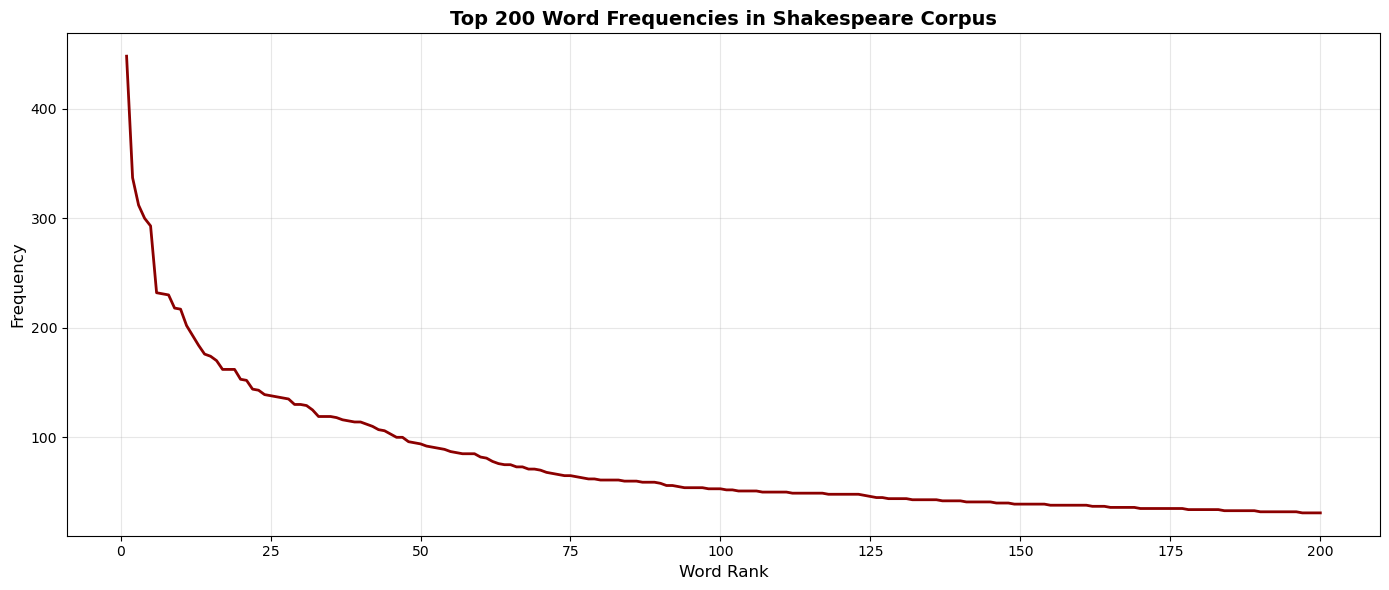

In [8]:
words_200 = [word for word, count in top_200]
counts_200 = [count for word, count in top_200]

plt.figure(figsize=(14, 6))
plt.plot(range(1, 201), counts_200, linewidth=2, color='darkred')
plt.xlabel('Word Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 200 Word Frequencies in Shakespeare Corpus', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Zipf's law predicts that $\alpha \approx 1.0$ and the calculated value from our data meets that condition. The high $R^2$ and extremely low p-value indicate a high degree of confidence in calculated value, and thus we can conclude the observed relative frequency of the corpus follows Zipf's law.

In [9]:
ranks = np.arange(1, len(word_freq) + 1)
frequencies = np.array([count for word, count in word_freq.most_common()])

log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_frequencies)

print(f"Zipf's Law Parameters:")
print(f"  Exponent (α): {-slope:.4f}")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  P-value: {p_value:.2e}")

Zipf's Law Parameters:
  Exponent (α): 0.9951
  R-squared: 0.9614
  P-value: 0.00e+00


Comparing the Shakespeare corpus to "all words in all corpora" which for our purposes we will take to mean the words present in the gutenberg corpora of the NLTK library, we see some obvious differences. There are almost as many unique non-stop words in the gutenberg corpora as there are total words in the Shakespeare portion and the most common words are, as one may expect, very different between the two bodies.

In [10]:
all_gutenberg_words = gutenberg.words()
all_gutenberg_lower = [word.lower() for word in all_gutenberg_words if word.isalpha()]
all_filtered = [word for word in all_gutenberg_lower if word not in stop_words]

all_word_freq = Counter(all_filtered)

print(f"Total Gutenberg corpus words: {len(all_filtered):,}")
print(f"Unique words in Gutenberg corpus: {len(set(all_filtered)):,}")

Total Gutenberg corpus words: 1,025,440
Unique words in Gutenberg corpus: 41,335


In [11]:
print("\nTop 15 words in Shakespeare vs. All Gutenberg:")
print(f"{'Rank':<6}{'Shakespeare':<20}{'Count':<10}{'All Gutenberg':<20}{'Count':<10}")
print("-" * 66)

shakespeare_top = word_freq.most_common(15)
all_top = all_word_freq.most_common(15)

for i in range(15):
    s_word, s_count = shakespeare_top[i]
    a_word, a_count = all_top[i]
    print(f"{i+1:<6}{s_word:<20}{s_count:<10,}{a_word:<20}{a_count:<10,}")


Top 15 words in Shakespeare vs. All Gutenberg:
Rank  Shakespeare         Count     All Gutenberg       Count     
------------------------------------------------------------------
1     haue                448       shall               11,682    
2     ham                 337       said                9,429     
3     thou                312       unto                9,010     
4     shall               300       lord                8,590     
5     lord                293       thou                6,759     
6     come                232       one                 6,218     
7     king                231       man                 5,615     
8     enter               230       thy                 5,609     
9     good                218       god                 5,287     
10    let                 217       thee                4,807     
11    thy                 202       ye                  4,674     
12    caesar              193       upon                4,587     
13    vs      

When we consider the distributions of the relative frequencies of the most common words we can see an interesting deviation from the norm in Shakespeare's work. The frequency drop off is much more gradual for Shakespeare's work than the corpus as a whole, particularly in the top 10 most common words. We can see the vocabulary richness of Shakespeare's work is significantly greater than that of the whole corpus, a feature common to author's considered classics.


Vocabulary Richness (unique words / total words):
  Shakespeare: 0.2006
  All Gutenberg: 0.0403


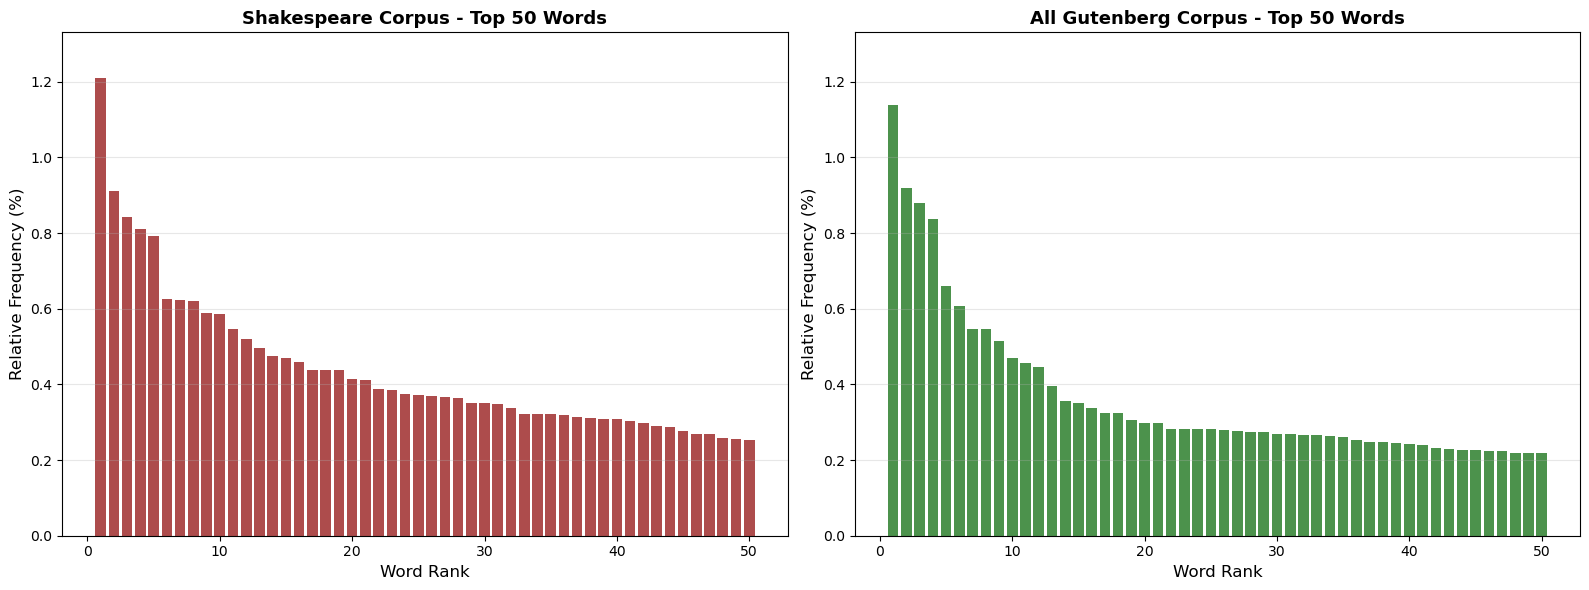

In [12]:
shakespeare_vocab_richness = len(set(filtered_words)) / len(filtered_words)
all_vocab_richness = len(set(all_filtered)) / len(all_filtered)

print(f"\nVocabulary Richness (unique words / total words):")
print(f"  Shakespeare: {shakespeare_vocab_richness:.4f}")
print(f"  All Gutenberg: {all_vocab_richness:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

top_50_s = word_freq.most_common(50)
counts_50_s = [count for word, count in top_50_s]
rel_freq_50_s = [count / total_word_count * 100 for count in counts_50_s]

ax1.bar(range(1, 51), rel_freq_50_s, color='darkred', alpha=0.7)
ax1.set_xlabel('Word Rank', fontsize=12)
ax1.set_ylabel('Relative Frequency (%)', fontsize=12)
ax1.set_title('Shakespeare Corpus - Top 50 Words', fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(max(rel_freq_50_s), 
                     max([count / len(all_filtered) * 100 for word, count in all_word_freq.most_common(50)])) * 1.1)
ax1.grid(True, alpha=0.3, axis='y')

top_50_all = all_word_freq.most_common(50)
counts_50_all = [count for word, count in top_50_all]
all_total = len(all_filtered)
rel_freq_50_all = [count / all_total * 100 for count in counts_50_all]

ax2.bar(range(1, 51), rel_freq_50_all, color='darkgreen', alpha=0.7)
ax2.set_xlabel('Word Rank', fontsize=12)
ax2.set_ylabel('Relative Frequency (%)', fontsize=12)
ax2.set_title('All Gutenberg Corpus - Top 50 Words', fontsize=13, fontweight='bold')
ax2.set_ylim(0, max(max(rel_freq_50_s), max(rel_freq_50_all)) * 1.1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()